In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import h5py


import torch
import torch.nn as nn

2022-12-14 03:54:55.346402: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-14 03:54:55.550684: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-14 03:54:55.550750: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-14 03:54:56.704628: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

In [23]:
from sklearn import preprocessing

### Let us take a look at our data
#### This station, 'RIO' is located at latitude = 34.10473 and longitude = -117.97956. That is just outside of Los Angeles. Situated pretty closely to the San Andreas Fault System and very densely populated with other stations making the same measurement. 


In [2]:
pd_dv = pd.read_csv('/home/jovyan/MLGEO2022-nichow3/KoopDV/KoopDV/DVV_test/CI.RIO.csv')
pd_dv.head()

,DATE,DVV,CC
0,1999-10-21,-0.765280,0.875691
1,1999-10-25,-0.759454,0.862668
2,1999-10-26,-0.802919,0.867514
3,1999-10-28,-0.934312,0.876715
4,1999-10-29,-1.474492,0.880135


In [3]:
#Rescaling

var = pd_dv['DVV']
Yraw = var.to_numpy().reshape(-1, 1)
scale = np.std(Yraw)
loc = np.mean(Yraw)
Y = (Yraw - loc) / scale


In [4]:
import matplotlib.dates as mdates

In [5]:
# 3: time vector


#Convert pandas datetime into numpy timestamp
dates = np.array(pd.to_datetime(pd_dv['DATE']))


# array of time stamps in seconds, but these are sampled each 10 day
tt = (pd.to_datetime(pd_dv['DATE']).values.astype(np.int64) // 10 ** 9 // 86400)



In [6]:
# converting time

#Convert pandas datetime --> numpy timestamp
dates = np.array(pd.to_datetime(pd_dv['DATE']))


# array of time stamps in seconds, but these are sampled each 10 day
tt = (pd.to_datetime(pd_dv['DATE']).values.astype(np.int64) // 10 ** 9 // 86400)

### We've taken our Seismic Data (The DV/V part) and rescaled it. We've also taken our time vector that was in date format and converted it from daily timestamps into seconds

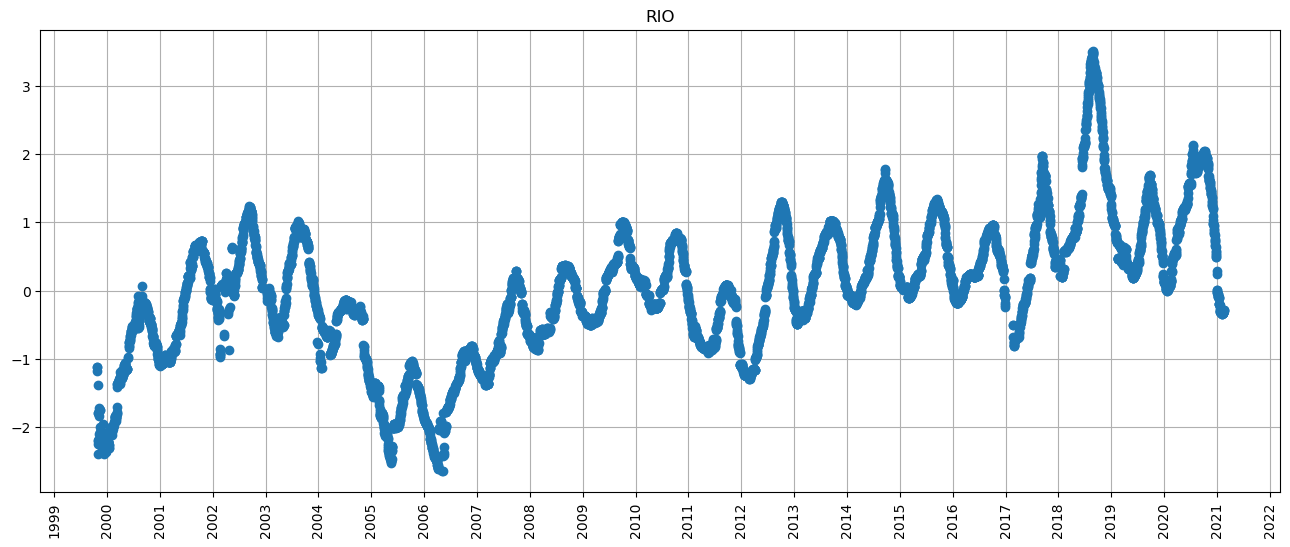

In [7]:
# Plotting rescaled Data
f, ax = plt.subplots(figsize=(16,6))
ax.plot_date(dates,Y)
ax.set_title('RIO')
xx = plt.xticks(rotation = 90)
fmt_half_yr = mdates.YearLocator()
ax.xaxis.set_major_locator(fmt_half_yr)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.grid(True)


In [8]:
# Fill in gaps in the data to make it smoother

from scipy.interpolate import interp1d
%matplotlib inline


# array of time stamps in days for the original data
tt = (pd.to_datetime(pd_dv['DATE']).values.astype(np.int64) // 10 ** 9 // 86400) 

# array of time stamps in days for the original data
tt_h = (pd.to_datetime(pd_dv['DATE']).values.astype(np.int64) // 10 ** 9 // 3600)

# new "dates" but sampled per hour
x = pd.date_range(min(dates),periods=22*365*24,freq="H")

# until the last day of record.
x = x[x<max(dates)] 

# convert new array to time stamp, 1 index per hour
xx= pd.to_datetime(x).values.astype(np.int64) // 10 ** 9 // 3600 




var1=np.zeros(len(tt_h))
var2=np.zeros(len(tt_h))
var1[:] = np.array(tt_h)
for i in range(len(tt_h)):
    var2[i]=Y[i]
var3 = interp1d(var1,var2)
Ynew = var3(xx)

(7602, 1)


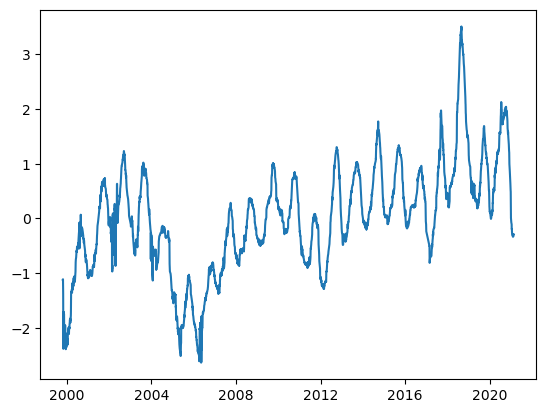

In [9]:
plt.plot(dates, Y)
print(Y.shape)

In [10]:
# Train the model

x_train,y_train = Y[:5300,:50],Y[:5300,-1] #training on 70% of data
x_val,y_val = Y[5300:6800,:50],Y[5300:6800,-1] # 20%
x_test,y_test = Y[6800:,:50],Y[6800:,-1] # 10%

In [11]:
x_train.shape

(5300, 1)

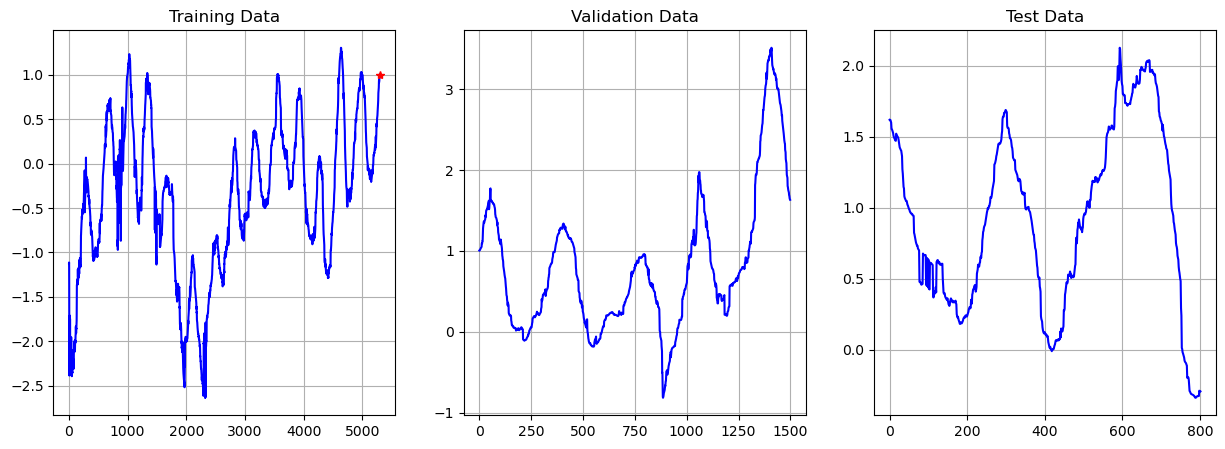

In [12]:
plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
plt.plot(x_train, 'b-')
plt.plot(5299, y_train[5299], 'r*')
plt.title("Training Data")
plt.grid(True)
plt.subplot(1,3,2)
plt.plot(x_val, 'b-')
plt.title("Validation Data")
plt.grid(True)
plt.subplot(1,3,3)
plt.plot(x_test, 'b-')
plt.title("Test Data")

plt.grid(True)


In [229]:
keras.backend.clear_session()

### Here, we take a few simple recurrent neural networks and stack them on top of each other. Using just one won't work. I found that even with stacking and fitting with 20 epochs output inconsistent and sometimes undesirable results. I kept the same stacks and upped the number of epochs to fit to 50 and we got a decent fit to our validation set. 

In [230]:
model=keras.models.Sequential([
    keras.layers.SimpleRNN(20,input_shape=[None,1],return_sequences=True),
    keras.layers.SimpleRNN(20,return_sequences=True),
    keras.layers.SimpleRNN(1)
    ])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, None, 20)          440       
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, None, 20)          820       
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 1)                 22        
                                                                 
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________


In [231]:
model.compile(optimizer='adam',loss='mse',metrics=['mse'])
history=model.fit(x_train,y_train,validation_data=(x_val,y_val), epochs=50, batch_size=128) 

Epoch 1/50
42/42 [==============================] - 5s 22ms/step - loss: 0.3409 - mse: 0.3409 - val_loss: 0.4521 - val_mse: 0.4521
Epoch 2/50
42/42 [==============================] - 0s 8ms/step - loss: 0.1459 - mse: 0.1459 - val_loss: 0.4091 - val_mse: 0.4091
Epoch 3/50
42/42 [==============================] - 0s 7ms/step - loss: 0.1390 - mse: 0.1390 - val_loss: 0.4055 - val_mse: 0.4055
Epoch 4/50
42/42 [==============================] - 0s 7ms/step - loss: 0.1381 - mse: 0.1381 - val_loss: 0.4047 - val_mse: 0.4047
Epoch 5/50
42/42 [==============================] - 0s 7ms/step - loss: 0.1376 - mse: 0.1376 - val_loss: 0.4041 - val_mse: 0.4041
Epoch 6/50
42/42 [==============================] - 0s 7ms/step - loss: 0.1371 - mse: 0.1371 - val_loss: 0.4038 - val_mse: 0.4038
Epoch 7/50
42/42 [==============================] - 0s 7ms/step - loss: 0.1367 - mse: 0.1367 - val_loss: 0.4035 - val_mse: 0.4035
Epoch 8/50
42/42 [==============================] - 0s 7ms/step - loss: 0.1363 - mse: 0.1

Text(0.5, 0, 'epochs')

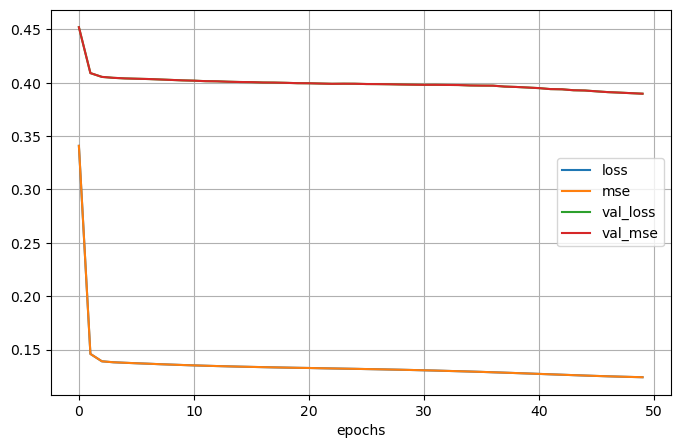

In [232]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.xlabel('epochs')


In [233]:
model=keras.models.Sequential([
    keras.layers.SimpleRNN(20,input_shape=[None,1],return_sequences=True),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
    ])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, None, 20)          440       
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 20)                820       
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


In [234]:
model.compile(optimizer='adam',loss='mse',metrics=['mse'])
history=model.fit(x_train,y_train,validation_data=(x_val,y_val), epochs=50, batch_size=128) 

Epoch 1/50
42/42 [==============================] - 3s 16ms/step - loss: 0.5315 - mse: 0.5315 - val_loss: 0.3741 - val_mse: 0.3741
Epoch 2/50
42/42 [==============================] - 0s 6ms/step - loss: 0.0322 - mse: 0.0322 - val_loss: 0.1260 - val_mse: 0.1260
Epoch 3/50
42/42 [==============================] - 0s 6ms/step - loss: 0.0176 - mse: 0.0176 - val_loss: 0.1237 - val_mse: 0.1237
Epoch 4/50
42/42 [==============================] - 0s 6ms/step - loss: 0.0147 - mse: 0.0147 - val_loss: 0.1169 - val_mse: 0.1169
Epoch 5/50
42/42 [==============================] - 0s 6ms/step - loss: 0.0122 - mse: 0.0122 - val_loss: 0.1121 - val_mse: 0.1121
Epoch 6/50
42/42 [==============================] - 0s 6ms/step - loss: 0.0100 - mse: 0.0100 - val_loss: 0.1047 - val_mse: 0.1047
Epoch 7/50
42/42 [==============================] - 0s 5ms/step - loss: 0.0083 - mse: 0.0083 - val_loss: 0.1020 - val_mse: 0.1020
Epoch 8/50
42/42 [==============================] - 0s 6ms/step - loss: 0.0069 - mse: 0.0

Text(0.5, 0, 'epochs')

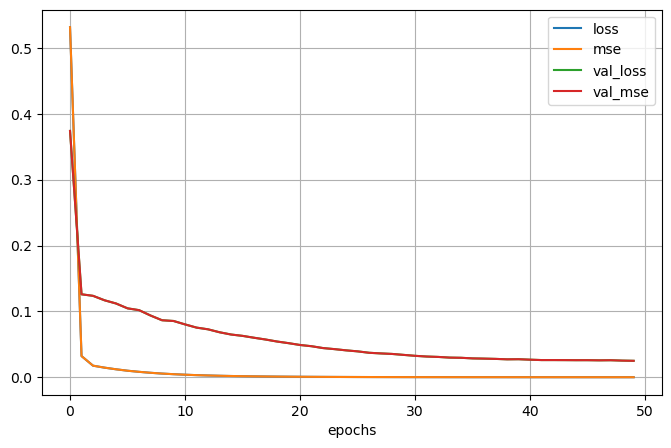

In [235]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.xlabel('epochs')

In [236]:
y_pred=model.predict(x_test)
print(y_pred.shape)
print(x_test.shape)
print(y_test.shape)

26/26 [==============================] - 0s 2ms/step
(802, 1)
(802, 1)
(802,)


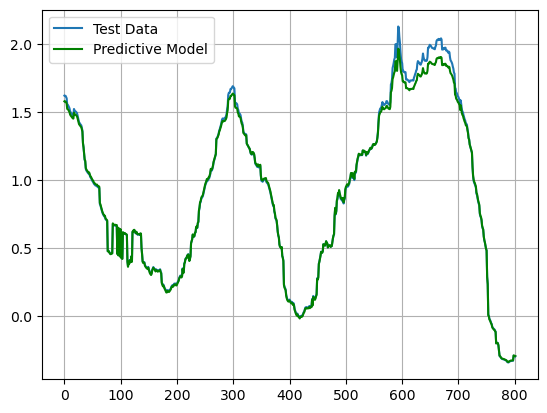

In [238]:
n_steps = 50
# plt.plot(np.arange(n_steps+10),x[9000,:])
plt.plot(x_test)
plt.plot(y_pred,'g')
plt.legend(('Test Data','Predictive Model'))
plt.grid(True)
# plt.xlim([300, 400])

### Here, we can see our test data (actual data from RIO that we set aside as a test set) compared to what our model predicts for the set durning the same timestamp. Just by eyeballing, this is a decent fit. Depending on what we are using this model for, the prediction may not be suitable for some purposes. It may very well be that the researcher utilizing the model requires a closer fit. That is, the size of the error between the test data and the predictive model must be closer to zero. We will try LSTM to see if we get an even better fit and then compare the two models to see which one performs better. 

In [ ]:
keras.backend.clear_session()

### 2. LSTM
Long-Short Term Memory are cells that aims to solve the memory loss issue.


In [15]:
model=keras.models.Sequential([
    keras.layers.LSTM(20,input_shape=[None,1],return_sequences=True),
    keras.layers.LSTM(20,return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(1))])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, None, 20)          1760      
                                                                 
 lstm_3 (LSTM)               (None, None, 20)          3280      
                                                                 
 time_distributed_1 (TimeDis  (None, None, 1)          21        
 tributed)                                                       
                                                                 
Total params: 5,061
Trainable params: 5,061
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mse'])
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs = 20, batch_size = 128) 

Epoch 1/20
42/42 [==============================] - 6s 37ms/step - loss: 0.8026 - mse: 0.8026 - val_loss: 1.4458 - val_mse: 1.4458
Epoch 2/20
42/42 [==============================] - 0s 10ms/step - loss: 0.7362 - mse: 0.7362 - val_loss: 1.6403 - val_mse: 1.6403
Epoch 3/20
42/42 [==============================] - 0s 9ms/step - loss: 0.7153 - mse: 0.7153 - val_loss: 1.9319 - val_mse: 1.9319
Epoch 4/20
42/42 [==============================] - 0s 8ms/step - loss: 0.7102 - mse: 0.7102 - val_loss: 2.0986 - val_mse: 2.0986
Epoch 5/20
42/42 [==============================] - 0s 8ms/step - loss: 0.7096 - mse: 0.7096 - val_loss: 2.1327 - val_mse: 2.1327
Epoch 6/20
42/42 [==============================] - 0s 8ms/step - loss: 0.7102 - mse: 0.7102 - val_loss: 2.1194 - val_mse: 2.1194
Epoch 7/20
42/42 [==============================] - 0s 8ms/step - loss: 0.7098 - mse: 0.7098 - val_loss: 2.1256 - val_mse: 2.1256
Epoch 8/20
42/42 [==============================] - 0s 7ms/step - loss: 0.7096 - mse: 0.

In [17]:
y_pred_lstm = model.predict(x_test)
y_pred_lstm.shape

26/26 [==============================] - 1s 2ms/step


(802, 1, 1)

### It looks like our model has an output that I wasn't expecting. When we ran our model above on Simple RNN, we got the expected dimensions of (802,1). Now, we are seeing y_pred_lstm has dimensions (802,1,1). This could prove problematic when we are visualizing Test Data vs. Predictive Data. We will reshape the predictive data and see what is happening with our output

In [44]:
y_pred_lstm_reshape = y_pred_lstm.reshape(802,1)



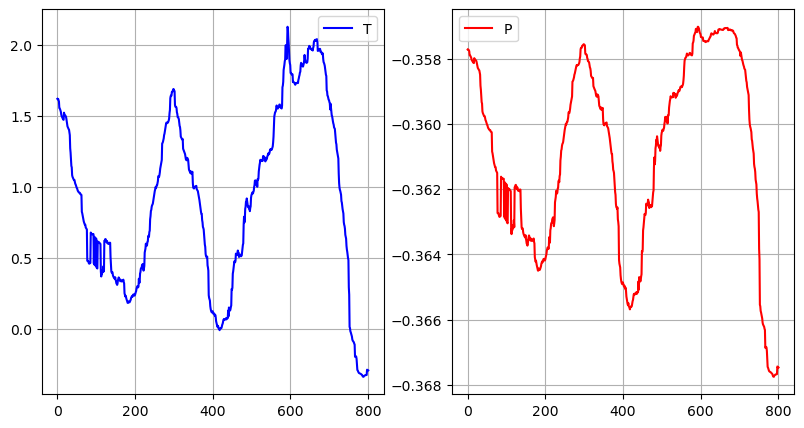

In [40]:
# plt.plot(Y[0,:])
plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
plt.plot(x_test,'b')
plt.grid(True)
plt.legend('Test Data')
plt.subplot(1,3,2)
plt.plot(y_pred_lstm_reshape, 'r')
plt.legend(('Prediction'))
plt.grid(True)

### The two curves actually have a surprisingly similar shape when plotted side by side. I have a hunch that if I normalize my predictive data over the range of my test values, that I may get a model that is comparable to my Simple RNN above. 

In [41]:

a = np.min(x_test)
b = np.max(x_test)
y_pred_lstm_reshape = a + ((y_pred_lstm_reshape - np.min(y_pred_lstm_reshape))*(b - a)) / (np.max(y_pred_lstm_reshape)-np.min(y_pred_lstm_reshape))

Text(0, 0.5, 'DV/V')

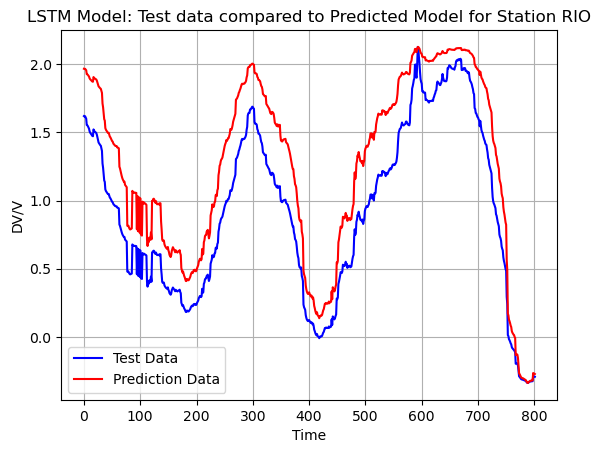

In [42]:
plt.grid(True)
plt.plot(x_test,'b')
plt.plot(y_pred_lstm_reshape, 'r')
plt.legend(['Test Data', 'Prediction Data'])
plt.grid(True)
plt.title('LSTM Model: Test data compared to Predicted Model for Station RIO')
plt.xlabel('Time')
plt.ylabel('DV/V')

### Doing a side by side comparison of test data vs. predictive data, we see that LSTM hasn't done a very good work of modeling off of our training set. There are certainly some features that our model did a great and surprising job of predicting. After normalizing our predicted model to fit the actual data, we see that LSTM captured some of the major features but it certainly didn't do as well as the Simple RNN. It is likely that there is some normalization out there that I am unaware of at the moment that will work better for this. I will continue working with this into the future to see if I can find a better fit. Work in progress. Future work into this data will likely include improvements to LSTM Model and creation and comparison of models for GRU and Deep Probabilistic Koopman. 